In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Проект "Классификация трафика"

Цель - разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный.

Задачи:

1) загрузить и изучить данные

2) провести предобработку данных

3) построить baseline модель

4) построить качественную модель

5) собрать REST API сервис

Оценивать качество модели будем по метрикам: precision, recall, f1, accuracy.

1) Загрузим и посмотрим какие есть данные

In [ ]:
!pip install catboost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn import metrics

from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import model_selection
from sklearn.ensemble import AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

import time

In [ ]:
RANDOM_STATE = 11023

In [ ]:
data = pd.read_csv('/content/network_traffic_data.csv', sep=',')

In [ ]:
data.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

In [ ]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,539616.000000,5.396160e+05,539616.000000,539616.000000,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,...,539616.000000,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05
mean,5563.061394,2.106693e+07,6.119972,5.985495,4.082371e+02,7.999779e+03,169.449966,11.855382,44.681011,59.525095,...,2.946516,-2.429314e+03,1.154984e+05,4.037570e+04,1.672882e+05,8.983017e+04,1.610155e+07,9.585649e+05,1.687227e+07,1.539150e+07
std,14921.262751,3.812172e+07,345.109317,463.490949,7.478351e+03,1.014442e+06,560.533869,60.961661,150.873880,217.729412,...,267.510434,1.052329e+06,7.787530e+05,4.347032e+05,1.059626e+06,7.099710e+05,3.315463e+07,6.461275e+06,3.403851e+07,3.295695e+07
min,0.000000,-1.200000e+01,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,80.000000,7.300000e+01,1.000000,1.000000,2.000000e+00,0.000000e+00,2.000000,0.000000,2.000000,0.000000,...,0.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,4.973900e+04,2.000000,2.000000,4.400000e+01,1.050000e+02,23.000000,0.000000,11.220000,0.000000,...,1.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,1.064030e+07,6.000000,5.000000,3.200000e+02,8.216250e+03,272.000000,6.000000,48.560000,91.700000,...,2.000000,3.200000e+01,6.000000e+00,0.000000e+00,6.000000e+00,5.000000e+00,7.125041e+06,0.000000e+00,7.143036e+06,6.028677e+06
max,65533.000000,1.200000e+08,200755.000000,270686.000000,2.866110e+06,5.910000e+08,24820.000000,2065.000000,5940.000000,7050.000000,...,192491.000000,1.380000e+02,1.020000e+08,6.350000e+07,1.020000e+08,1.020000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


В значениях есть бесконечные значения, пропуски, столбцы с полностью нулевыми значениями, рассмотрим их позже подробнее

2) Проведем предобработку данных

Сначала приведем столбцы к змеиному регистру

In [ ]:
data.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [ ]:
data.columns = (data.columns.str.lstrip().str.replace('(?<=[a-z])(?=[A-Z])','_',regex=True).str.replace(' ','_').str.replace('/','_').str.replace('.','_').str.lower())

In [ ]:
data.columns

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

Посмотрим на бесконечные значения, они есть в двух столбцах 'flow_bytes_s', 'flow_packets_s'

In [ ]:
data['flow_bytes_s'].value_counts().sort_values(ascending=False)

0.000000         74100
186046.511600     3381
181818.181800     3219
139534.883700     3034
136363.636400     3000
                 ...  
1130.132934          1
1135.431168          1
1150.358189          1
1133.821318          1
364.568811           1
Name: flow_bytes_s, Length: 324167, dtype: int64

In [ ]:
data['flow_packets_s'].value_counts().sort_values(ascending=False)

6.666667e+05    14506
5.000000e+05     9656
2.000000e+06     6975
4.651163e+04     6589
4.545455e+04     6094
                ...  
1.016251e+00        1
9.380014e-01        1
1.094354e+00        1
9.381321e-01        1
8.686414e-01        1
Name: flow_packets_s, Length: 301150, dtype: int64

Заменим бесконечные значения медианой

In [ ]:
data['flow_bytes_s'] = data['flow_bytes_s'].replace([np.inf, -np.inf], data['flow_bytes_s'].median())

In [ ]:
data['flow_packets_s'] = data['flow_packets_s'].replace([np.inf, -np.inf], data['flow_packets_s'].median())

Проверим пропуски

In [ ]:
data.isna().sum().sort_values(ascending=False)

flow_bytes_s            488
destination_port          0
bwd_avg_bytes_bulk        0
fwd_avg_packets_bulk      0
fwd_avg_bytes_bulk        0
                       ... 
bwd_iat_mean              0
bwd_iat_total             0
fwd_iat_min               0
fwd_iat_max               0
label                     0
Length: 79, dtype: int64

Есть пропуски в столбцу Flow Bytes/s, заполним медианным значением, чтобы не удалять их

In [ ]:
data['flow_bytes_s'] = data['flow_bytes_s'].fillna(data['flow_bytes_s'].median())

In [ ]:
data.isna().sum().sort_values(ascending=False)

destination_port        0
ece_flag_count          0
fwd_avg_packets_bulk    0
fwd_avg_bytes_bulk      0
fwd_header_length_1     0
                       ..
bwd_iat_total           0
fwd_iat_min             0
fwd_iat_max             0
fwd_iat_std             0
label                   0
Length: 79, dtype: int64

Нужно закодировать целевой признак для моделей

In [ ]:
data['label'].value_counts()

BENIGN                        240000
DoS Hulk                      115974
PortScan                       79660
DDoS                           64366
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: label, dtype: int64

In [ ]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [ ]:
data['label'].value_counts()

0     240000
4     115974
10     79660
2      64366
3      10293
7       7938
11      5897
6       5796
5       5499
1       1966
12      1507
14       652
9         36
13        21
8         11
Name: label, dtype: int64

В целевом признаке наблюдаем дисбаланс классов

Посмотрим на данные более подробно, посмотрим какие есть значения в столбцах и определим есть ли в таблице категориальные данные

In [ ]:
for c in data.columns:
    print("---- %s ---" % c)
    print(data[c].value_counts())
    print('Количество уникальных значений в столбце равно', data[c]. nunique())

---- destination_port ---
80       229165
53       101315
443       53430
21         8638
22         7245
          ...  
62846         1
61995         1
64275         1
41909         1
3051          1
Name: destination_port, Length: 24926, dtype: int64
Количество уникальных значений в столбце равно 24926
---- flow_duration ---
3            16755
4            10533
1             7021
43            6678
44            6129
             ...  
116874184        1
107391           1
19487            1
14850048         1
11512230         1
Name: flow_duration, Length: 280102, dtype: int64
Количество уникальных значений в столбце равно 280102
---- total_fwd_packets ---
2       147122
1       140971
3        53671
8        29071
5        28292
         ...  
843          1
635          1
512          1
1195         1
590          1
Name: total_fwd_packets, Length: 510, dtype: int64
Количество уникальных значений в столбце равно 510
---- total_backward_packets ---
1       157388
0       101070
2

Есть столбцы с нулевыми значениями, их нужно удалить, так как они не несут никакой информативности

In [ ]:
data = data.drop(columns=['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk',
                          'fwd_avg_packets_bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk',
                          'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate'], axis=1)

Также есть категориальные данные, это надо учесть и не применять к ним далее масштабирование, для удобства внесем их в переменные

In [ ]:
cat_features = ['fwd_psh_flags', 'fwd_urg_flags', 'fin_flag_count',
                    'syn_flag_count', 'rst_flag_count', 'psh_flag_count',
                    'ack_flag_count', 'urg_flag_count', 'cwe_flag_count',
                    'ece_flag_count']

In [ ]:
numeric = ['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 'bwd_header_length', 'fwd_packets_s',
       'bwd_packets_s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'average_packet_size', 'avg_fwd_segment_size',
       'avg_bwd_segment_size', 'fwd_header_length_1', 'subflow_fwd_packets',
       'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes',
       'init_win_bytes_forward', 'init_win_bytes_backward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'active_mean', 'active_std', 'active_max',
       'active_min', 'idle_mean', 'idle_std', 'idle_max', 'idle_min', 'down_up_ratio']

Посмотрим на корреляцию признаков

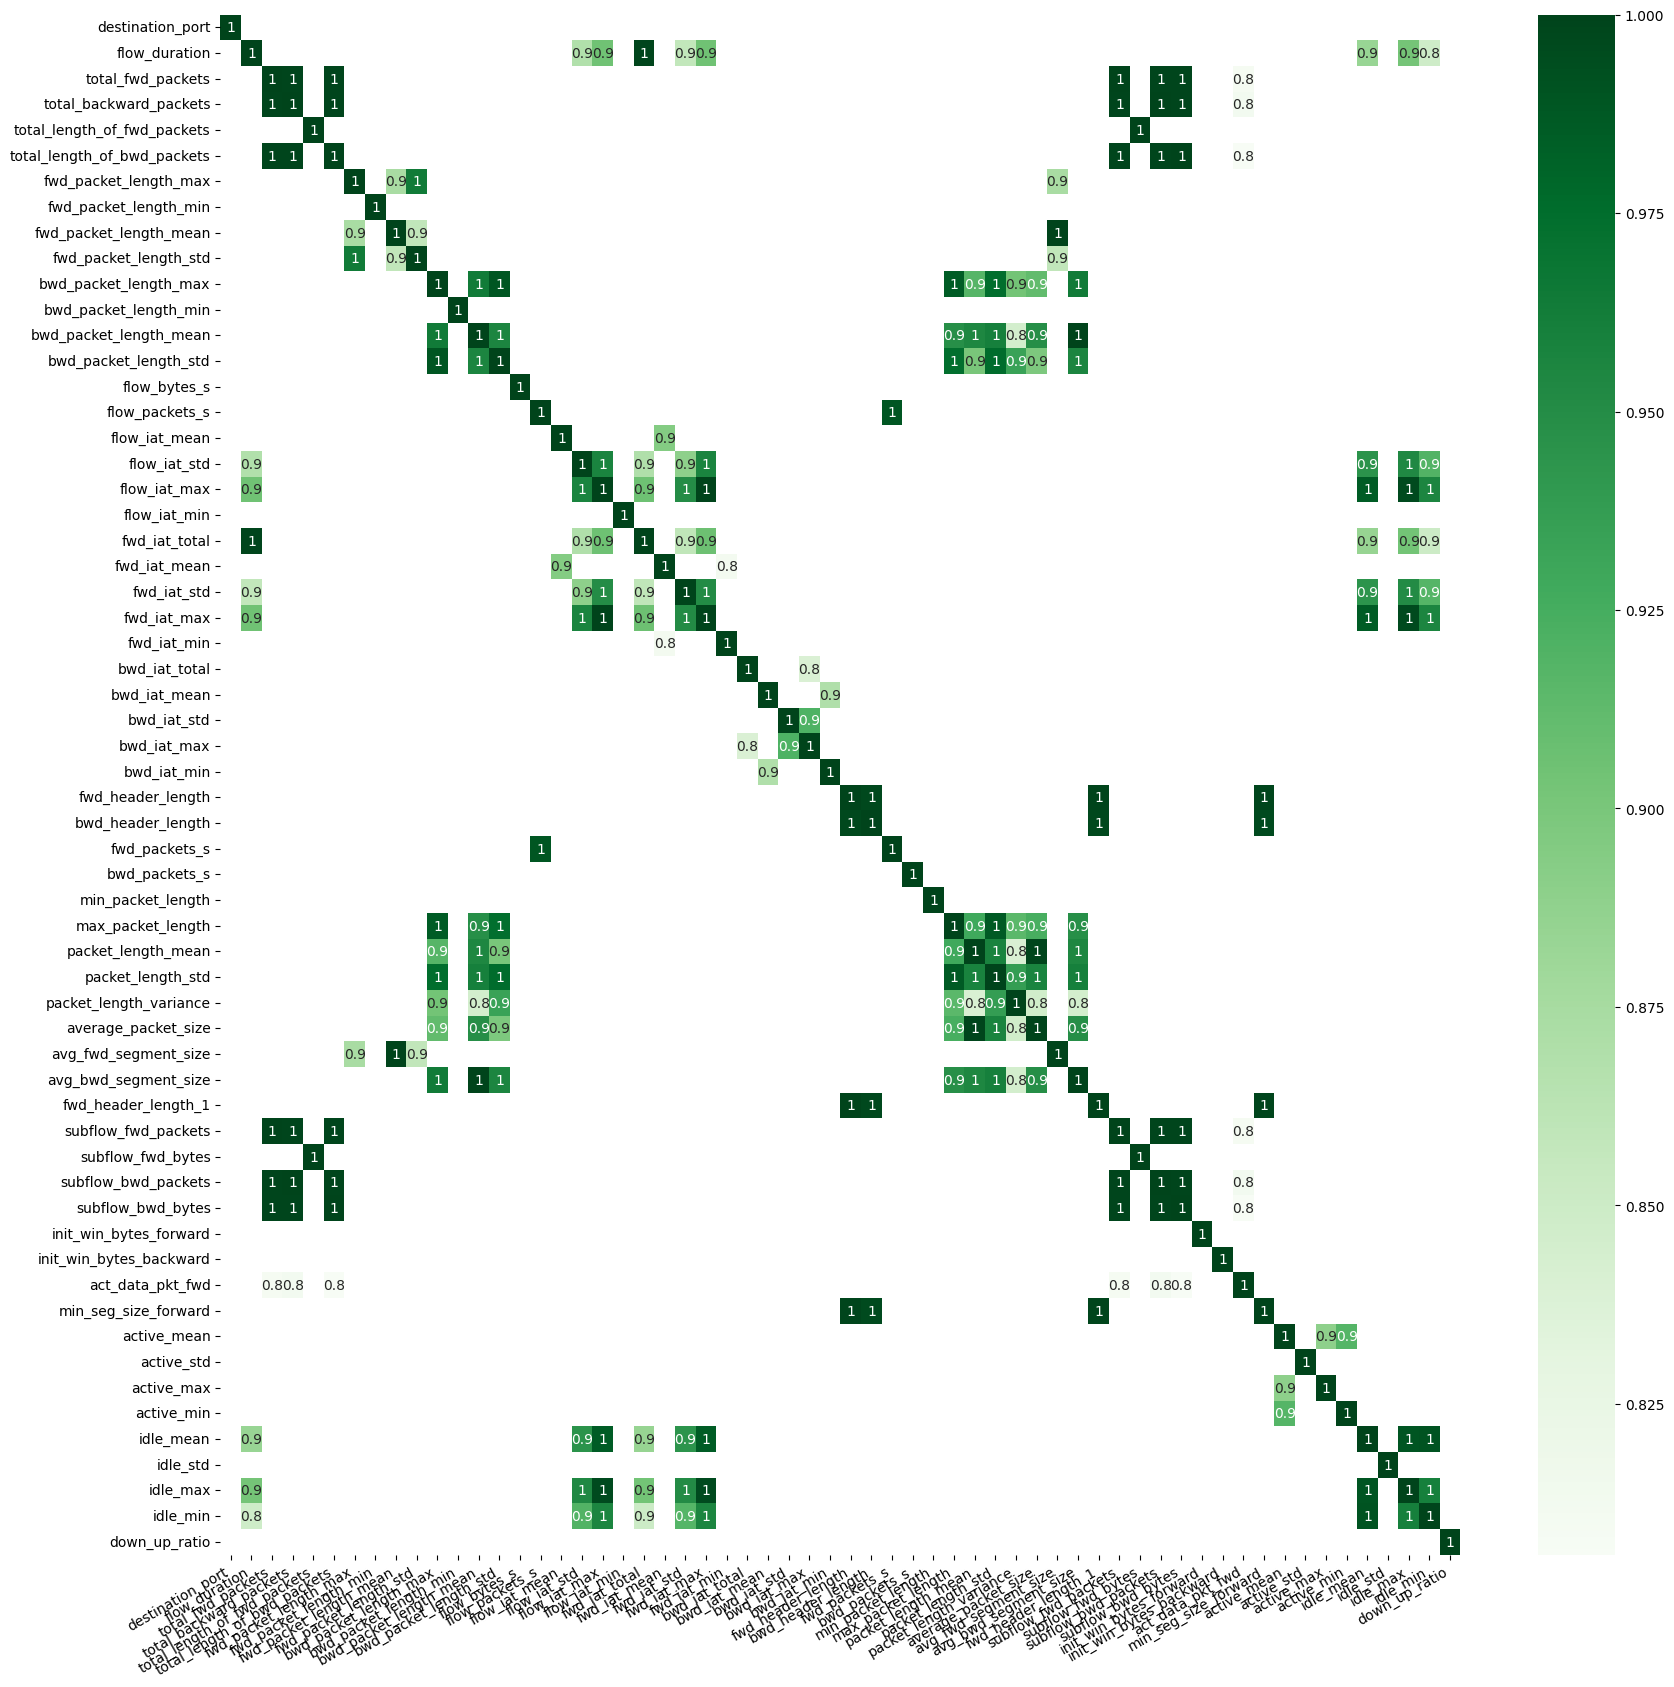

In [ ]:
corr = data[numeric].corr()
plt.figure(figsize=(20,20))
corr_m = corr[corr>=.8]
g = sns.heatmap(corr_m, annot=True, fmt='.1g', cmap='Greens')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30)
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

Есть сильная корреляция между некоторыми признаками, нужно убрать сильнокоррелирующие признаки

In [ ]:
data = data.drop(columns = ['total_fwd_packets',
       'total_backward_packets', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_iat_std', 'flow_iat_max',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance', 'avg_fwd_segment_size',
       'avg_bwd_segment_size', 'fwd_header_length_1', 'subflow_fwd_bytes', 'subflow_bwd_bytes', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'active_mean', 'active_std', 'idle_mean', 'subflow_fwd_packets',
       'subflow_bwd_packets', 'fwd_packets_s', 'bwd_packet_length_max', 'idle_max', 'idle_min', 'bwd_header_length'], axis=1)

In [ ]:
numeric_new = ['destination_port', 'flow_duration','total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min',
       'bwd_packet_length_min', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_min', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length',
       'bwd_packets_s', 'min_packet_length', 'average_packet_size', 'init_win_bytes_forward', 'init_win_bytes_backward', 'active_max',
       'active_min', 'idle_std', 'down_up_ratio']

Подготовим данные к обучению и разделению выборок

In [ ]:
features = data.drop('label', axis=1)
target = data['label']

Разделим данные на обучающую и тестовую выборку

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=RANDOM_STATE)

Проведем масштабирование данных

In [ ]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()

scaler.fit(features_train[numeric_new])

features_train[numeric_new] = scaler.transform(features_train[numeric_new])

features_test[numeric_new] = scaler.transform(features_test[numeric_new])

print(features_train.head(), features_test.head())

        destination_port  flow_duration  total_length_of_fwd_packets  \
450712         -0.368411       0.053392                    -0.051589   
374657         -0.368411       1.207975                     0.026395   
530011         -0.368411       0.090616                     0.028462   
258029         -0.368411      -0.548324                    -0.007637   
437328         -0.368411      -0.496030                    -0.051589   

        total_length_of_bwd_packets  fwd_packet_length_max  \
450712                    -0.007482              -0.291270   
374657                     0.002758               0.224748   
530011                     0.002791               0.788975   
258029                     0.002758               0.321167   
437328                    -0.007482              -0.291270   

        fwd_packet_length_min  bwd_packet_length_min  flow_bytes_s  \
450712              -0.095613              -0.424735     -0.045728   
374657              -0.193794              -0.424735  

Вывод: провели предобработку данных, привели столбцы к змеиному регистру, поработали с пропусками и бесконечными значениями, определили числовые и категориальные данные, удалили неинформативные столбцы, посмотрели на корреляцию признаков, удалили сильнокоррелирующие признаки, разделили данные на обучающую и тестовую выборки, провели масштабирование данных.

3) построим baseline модель

Построим baseline, возьмем логистическую регрессию

In [ ]:
logistic_regression = LogisticRegression()
f1 = cross_val_score(logistic_regression, features_train, target_train, scoring='f1_weighted', cv=3).mean()
recall = cross_val_score(logistic_regression, features_train, target_train, scoring = 'recall_macro', cv=3).mean()
precision = cross_val_score(logistic_regression, features_train, target_train, scoring='precision_macro', cv=3).mean()
accuracy = cross_val_score(logistic_regression, features_train, target_train, scoring='accuracy', cv=3).mean()

metrics_report = {'metric':['f1', 'recall', 'precision', 'accuracy'],
              'score':[f1, recall, precision, accuracy]
              }
print(pd.DataFrame(metrics_report))

      metric     score
0         f1  0.953032
1     recall  0.595939
2  precision  0.737707
3   accuracy  0.956935


4) построим качественную модель

Попробуем разные модели вместе с настройками по умолчанию

In [ ]:
def model_select(model, features, target):
    f1 = cross_val_score(model, features, target, scoring='f1_weighted', cv=3).mean()
    recall = cross_val_score(model, features, target, scoring = 'recall_macro', cv=3).mean()
    precision = cross_val_score(model, features, target, scoring='precision_macro', cv=3).mean()
    accuracy = cross_val_score(model, features, target, scoring='accuracy', cv=3).mean()
    metrics_report = {'metric':['f1', 'recall', 'precision', 'accuracy'],
              'score':[f1, recall, precision, accuracy]
              }
    return pd.DataFrame(metrics_report)

In [ ]:
model_select(DecisionTreeClassifier(random_state=RANDOM_STATE), features_train, target_train)

,metric,score
0,f1,0.996630
1,recall,0.873296
2,precision,0.857017
3,accuracy,0.996623


In [ ]:
model_select(RandomForestClassifier(random_state=RANDOM_STATE), features_train, target_train)

,metric,score
0,f1,0.997264
1,recall,0.837674
2,precision,0.949071
3,accuracy,0.997568


In [ ]:
model_select(CatBoostClassifier(random_state=RANDOM_STATE, task_type='GPU'), features_train, target_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 0.3300202	total: 194ms	remaining: 38.7s
5:	learn: 0.2843670	total: 239ms	remaining: 39.6s
6:	learn: 0.2399914	total: 264ms	remaining: 37.4s
7:	learn: 0.2042389	total: 285ms	remaining: 35.3s
8:	learn: 0.1739013	total: 307ms	remaining: 33.8s
9:	learn: 0.1526485	total: 327ms	remaining: 32.4s
10:	learn: 0.1357906	total: 347ms	remaining: 31.2s
11:	learn: 0.1242811	total: 367ms	remaining: 30.3s
12:	learn: 0.1102515	total: 389ms	remaining: 29.6s
13:	learn: 0.0999494	total: 421ms	remaining: 29.6s
14:	learn: 0.0902629	total: 439ms	remaining: 28.9s
15:	learn: 0.0825126	total: 458ms	remaining: 28.2s
16:	learn: 0.0766801	total: 488ms	remaining: 28.2s
17:	learn: 0.0703625	total: 507ms	remaining: 27.6s
18:	learn: 0.0657398	total: 527ms	remaining: 27.2s
19:	learn: 0.0602357	total: 547ms	remaining: 26.8s
20:	learn: 0.0562031	total: 567ms	remaining: 26.4s
21:	learn: 0.0523787	total: 589ms	remaining: 26.2s
22:	learn: 0.0492030

,metric,score
0,f1,0.997523
1,recall,0.863152
2,precision,0.914452
3,accuracy,0.997633


In [ ]:
model_select(AdaBoostClassifier(random_state=RANDOM_STATE), features_train, target_train)

,metric,score
0,f1,0.478281
1,recall,0.177746
2,precision,0.131157
3,accuracy,0.590060


По показателям лучшая модель CatBoostClasifier, сделаем перебор параметров для нее

In [ ]:
def parameters_model(features, target, model, param_grid):
    gr = model(random_state=RANDOM_STATE, task_type='GPU')
    scoring = ['accuracy', 'f1_weighted', 'recall_macro', 'precision_macro']
    grid = GridSearchCV(gr, param_grid, scoring=scoring, n_jobs=-1, cv=3, refit='f1_weighted', return_train_score=True)
    grid = grid.fit(features, target)
    parameters = grid.best_params_
    f1 = grid.best_score_
    return f1, parameters

In [ ]:
cat_f1, cat_param = parameters_model(features_train, target_train, CatBoostClassifier, param_grid={'depth' : [2,6,8,10],
              'learning_rate' : [0.1, 0.2, 0.5],
              'iterations'    : [200, 400, 600]
              })
cat_f1, cat_param

0:	learn: 0.6348495	total: 174ms	remaining: 1m 43s
1:	learn: 0.4834811	total: 286ms	remaining: 1m 25s
2:	learn: 0.3804502	total: 383ms	remaining: 1m 16s
3:	learn: 0.3068195	total: 470ms	remaining: 1m 9s
4:	learn: 0.2497878	total: 559ms	remaining: 1m 6s
5:	learn: 0.2052119	total: 670ms	remaining: 1m 6s
6:	learn: 0.1681782	total: 751ms	remaining: 1m 3s
7:	learn: 0.1405147	total: 842ms	remaining: 1m 2s
8:	learn: 0.1187784	total: 932ms	remaining: 1m 1s
9:	learn: 0.1008605	total: 1.02s	remaining: 1m
10:	learn: 0.0853417	total: 1.11s	remaining: 59.4s
11:	learn: 0.0735836	total: 1.2s	remaining: 59s
12:	learn: 0.0638110	total: 1.29s	remaining: 58.1s
13:	learn: 0.0558403	total: 1.37s	remaining: 57.2s
14:	learn: 0.0491765	total: 1.45s	remaining: 56.7s
15:	learn: 0.0434908	total: 1.54s	remaining: 56.2s
16:	learn: 0.0387053	total: 1.62s	remaining: 55.5s
17:	learn: 0.0347286	total: 1.72s	remaining: 55.5s
18:	learn: 0.0313151	total: 1.8s	remaining: 55s
19:	learn: 0.0283568	total: 1.89s	remaining: 54

(0.9975526565043582, {'depth': 10, 'iterations': 600, 'learning_rate': 0.2})

In [ ]:
cat_test_model = CatBoostClassifier(random_state=RANDOM_STATE, depth=10, iterations=600, learning_rate=0.2)
cat_test_model.fit(features_train, target_train)
cat_predicted_test = cat_test_model.predict(features_test)
print(classification_report(target_test, cat_predicted_test))

0:	learn: 0.6641287	total: 5.17s	remaining: 51m 35s
1:	learn: 0.5040407	total: 11.1s	remaining: 55m 27s
2:	learn: 0.3944853	total: 19.3s	remaining: 1h 4m 6s
3:	learn: 0.3166346	total: 25s	remaining: 1h 2m 12s
4:	learn: 0.2579196	total: 29.6s	remaining: 58m 36s
5:	learn: 0.2123355	total: 35.2s	remaining: 58m 6s
6:	learn: 0.1773405	total: 40.1s	remaining: 56m 36s
7:	learn: 0.1486062	total: 44.4s	remaining: 54m 47s
8:	learn: 0.1256484	total: 55.1s	remaining: 1h 19s
9:	learn: 0.1048042	total: 1m 6s	remaining: 1h 5m 17s
10:	learn: 0.0894444	total: 1m 13s	remaining: 1h 5m 28s
11:	learn: 0.0768916	total: 1m 23s	remaining: 1h 7m 59s
12:	learn: 0.0664330	total: 1m 27s	remaining: 1h 5m 53s
13:	learn: 0.0577744	total: 1m 33s	remaining: 1h 5m 7s
14:	learn: 0.0508082	total: 1m 37s	remaining: 1h 3m 39s
15:	learn: 0.0448286	total: 1m 42s	remaining: 1h 2m 14s
16:	learn: 0.0400563	total: 1m 48s	remaining: 1h 2m 8s
17:	learn: 0.0359181	total: 1m 53s	remaining: 1h 55s
18:	learn: 0.0323702	total: 1m 57s	r

In [ ]:
cat_test_model.save_model('catboost_model')